In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import jax
import jax.numpy as jnp

import shortfall.gradient.base_cost_models as bcm
import shortfall.gradient.optimize_repay_ratchet as orr

In [5]:
initial_pledge_projection_period_days = 20
token_lease_fee = 0.2
supply_lock_target = 0.3

# define various loss functions to explore
sampling_rate = 30  # sampling rate of the income curve
    
def get_incomes(x):
    base_stats = bcm.compute_baseline(initial_pledge_projection_period_days, token_lease_fee, supply_lock_target)
    burn_stats = orr.compute_repay_ratchet(x)

    indices = np.arange(sampling_rate, len(burn_stats), sampling_rate)
    # extract the quantities of interest
    income_burn = jnp.asarray([burn_stats[ii]['net_equity'] for ii in indices])
    income_base = bcm.compute_income(base_stats, borrow_amt=orr.BORROW_AMT, apy=orr.APY, sampling_rate_days=orr.SAMPLING_RATE_DAYS)
    
    return income_base, income_burn

def mse_loss(x):
    income_base, income_burn = get_incomes(x)
    mse_loss = jnp.mean(jnp.power(income_base - income_burn, 2)) / len(income_base)
    return mse_loss

In [6]:
max_fee_reward_fraction_vec = np.linspace(0.1, 0.9, 10)  # y
token_lease_fee_vec = np.linspace(0.1, 0.9, 8)  # x
max_repayment_term = 3 * 365.

loss_surface = np.zeros((len(max_fee_reward_fraction_vec), len(token_lease_fee_vec)))
for ii in range(len(max_fee_reward_fraction_vec)):
    for jj in range(len(token_lease_fee_vec)):
        x = jnp.asarray([max_fee_reward_fraction_vec[ii], token_lease_fee_vec[jj], max_repayment_term])
        loss_surface[ii,jj] = mse_loss(x)

Text(0.5, 1.0, 'Repay')

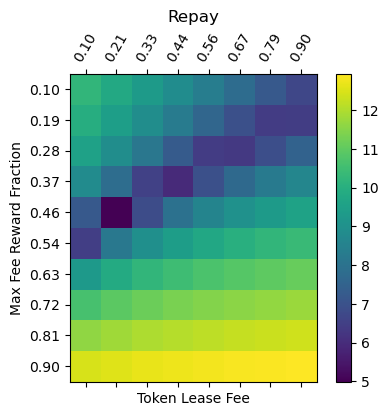

In [14]:
fig, ax = plt.subplots(figsize=[5, 4])

xt = ['%0.02f' % (x,) for x in token_lease_fee_vec]
yt = ['%0.02f' % (x,) for x in max_fee_reward_fraction_vec]

z = ax.matshow(np.log(loss_surface))
ax.set_xticks(range(len(xt)))
ax.set_yticks(range(len(yt)))
ax.set_xticklabels(xt, rotation=60)
ax.set_yticklabels(yt)
ax.set_xlabel('Token Lease Fee')
ax.set_ylabel('Max Fee Reward Fraction')


fig.colorbar(z)
plt.title('Repay')

In [9]:
income_base, repay1 = get_incomes([0.1, 0.1, max_repayment_term])
_, repay2 = get_incomes([0.5, 0.5, max_repayment_term])
_, repay3 = get_incomes([0.9, 0.9, max_repayment_term])

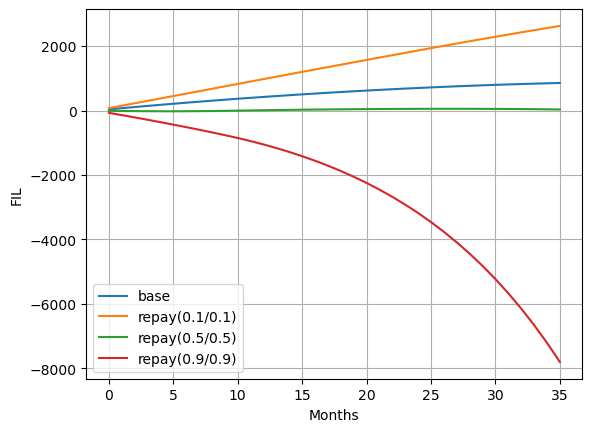

In [10]:
plt.figure()
plt.plot(income_base, label='base')
plt.plot(repay1, label='repay(0.1/0.1)')
plt.plot(repay2, label='repay(0.5/0.5)')
plt.plot(repay3, label='repay(0.9/0.9)')

plt.xlabel('Months')
plt.ylabel('FIL')
plt.grid()
plt.legend()